**Author**: Petru Potrimba <br>
**Matriculation**:  928850

# Visual Inspection of Motorcycle Connecting Rods

### Utility functions

In [193]:
def defect_convexity_algorithm(img):
    
    contours, hierarchy = cv.findContours(img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    sepc = -1
    for i in range(len(contours)):
        if(len(contours[i])) >= 326: # there are touching elements
            sepc = i
            break
    
    cnt = contours[sepc]
    hull = cv.convexHull(cnt, returnPoints = False)
    defects = cv.convexityDefects(cnt, hull)

    collision_points = []
    
    if sepc != -1: # if sepc is different from "-1", it means that there are touching rods
         for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            far = tuple(cnt[f][0])
            if (far[0] - 1 >= 0) and (far[1] - 1 >= 0) and (far[0] + 1 <= 255) and (far[1] + 1 <= 255) and (far[0] - 2 >= 0) and (far[1] - 2 >= 0) and (far[0] + 2 <= 255) and (far[1] + 2 <= 255):
                octet_sum = int(img[far[1] - 1, far[0]]) + int(img[far[1] - 1, far[0] - 1]) + int(img[far[1], far[0] - 1]) + int(img[far[1] + 1, far[0] - 1]) + int(img[far[1] + 1, far[0]]) + int(img[far[1] + 1, far[0] + 1]) + int(img[far[1], far[0] + 1]) + int(img[far[1] - 1, far[0] + 1]) + int(img[far[1] - 2, far[0]]) + int(img[far[1] - 2, far[0] - 1]) + int(img[far[1] - 2, far[0] - 2]) + int(img[far[1] -1, far[0] - 2]) + int(img[far[1], far[0] - 2]) + int(img[far[1] + 1, far[0] - 2]) + int(img[far[1] + 2,far[0] - 2]) + int(img[far[1] + 2, far[0] - 1]) + int(img[far[1] + 2, far[0]]) + int(img[far[1] + 2, far[0] + 1]) + int(img[far[1] + 2, far[0] + 2]) + int(img[far[1] + 1, far[0] + 2]) + int(img[far[1], far[0] + 2]) + int(img[far[1] - 1, far[0] + 2]) + int(img[far[1] - 2, far[0] + 2]) + int(img[far[1] - 2, far[0] + 1])
                collision_points.append([far, octet_sum, False])
            
    if len(collision_points) > 0:
        # calculate threshold            
        white_pixel_value_sum = []
        for i in range(len(collision_points)):
            white_pixel_value_sum.append(collision_points[i][1])
        remove_duplicate_list = np.sort(list(set(white_pixel_value_sum)))

        changes_between_values = []
        for i in range(len(remove_duplicate_list) - 1):
            changes_between_values.append(remove_duplicate_list[i + 1] - remove_duplicate_list[i])
        max_change = np.argmax(changes_between_values)
        threshold = int(round((remove_duplicate_list[max_change + 1] + remove_duplicate_list[max_change]) / 2))
    

        # calculate euclidean distance
        for i in range(len(collision_points) - 1):
            distance_from_i_to_j = math.inf
            index_of_j = -1
            if collision_points[i][1] <= threshold and collision_points[i][2] == False: # means that still need to find its miniumum distance point
                for j in range(i + 1, len(collision_points)):
                    dst = distance.euclidean([collision_points[i][0][0], collision_points[i][0][1]], [collision_points[j][0][0], collision_points[j][0][1]])
                    if dst < distance_from_i_to_j and collision_points[j][2] == False:
                        distance_from_i_to_j = dst
                        index_of_j = j
                # draw line
                cv.line(img,(collision_points[i][0][0],collision_points[i][0][1]),(collision_points[index_of_j][0][0],collision_points[index_of_j][0][1]),(255,0, 0),1)
                collision_points[i][2] = True
                collision_points[index_of_j][2] = True
                
    return img, collision_points

def compute_width_at_barycenter(barX, barY, contours):
    max_distance_from_bar = - math.inf
    index_of_j = -1
    for j in range(len(contours[i])):
        dst = distance.euclidean([barX, barY], [contours[j][0][0], contours[j][0][1]])
        if dst > max_distance_from_bar:
            max_distance_from_bar = dst
            index_of_j = j

    x1 = contours[index_of_j][0][0]
    x2 = round(barX)
    y1 = contours[index_of_j][0][1]
    y2 = round(barY)
    xdif = x2 - x1
    ydif = y2 - y1

    line_len_at_barycenter = 3

    a1 = int(round(x2 - ydif / line_len_at_barycenter))
    b1 = int(round(y2 + xdif / line_len_at_barycenter))

    a2 = int(round(x2 + ydif / line_len_at_barycenter))
    b2 = int(round(y2 - xdif / line_len_at_barycenter))

    distance_from_i_to_j = math.inf
    index_of_j = -1
    for j in range(len(contours)):
        dst = distance.euclidean([a1, b1], [contours[j][0][0], contours[j][0][1]])
        if dst < distance_from_i_to_j:
            distance_from_i_to_j = dst
            index_of_j = j

    distance_from_i_to_k = math.inf
    index_of_k = -1

    for k in range(len(contours)):
        dst = distance.euclidean([a2, b2], [contours[k][0][0], contours[k][0][1]])
        if dst <= distance_from_i_to_k:
            distance_from_i_to_k = dst
            index_of_k = k
    return distance.euclidean([contours[index_of_j][0][0], contours[index_of_j][0][1]], [contours[index_of_k][0][0], contours[index_of_k][0][1]])

In [194]:
def compute_width_at_barycenter2(barX, barY, contours):
    max_distance_from_bar = - math.inf
    index_of_j = -1
    for j in range(len(contours[i])):
        dst = distance.euclidean([barX, barY], [contours[j][0][0], contours[j][0][1]])
        if dst > max_distance_from_bar:
            max_distance_from_bar = dst
            index_of_j = j

    x1 = contours[index_of_j][0][0]
    x2 = round(barX)
    y1 = contours[index_of_j][0][1]
    y2 = round(barY)
    xdif = x2 - x1
    ydif = y2 - y1

    line_len_at_barycenter = 3

    a1 = int(round(x2 - ydif / line_len_at_barycenter))
    b1 = int(round(y2 + xdif / line_len_at_barycenter))

    a2 = int(round(x2 + ydif / line_len_at_barycenter))
    b2 = int(round(y2 - xdif / line_len_at_barycenter))

    distance_from_i_to_j = math.inf
    index_of_j = -1
    for j in range(len(contours)):
        dst = distance.euclidean([a1, b1], [contours[j][0][0], contours[j][0][1]])
        if dst < distance_from_i_to_j:
            distance_from_i_to_j = dst
            index_of_j = j

    distance_from_i_to_k = math.inf
    index_of_k = -1

    for k in range(len(contours)):
        dst = distance.euclidean([a2, b2], [contours[k][0][0], contours[k][0][1]])
        if dst <= distance_from_i_to_k:
            distance_from_i_to_k = dst
            index_of_k = k
    return contours[index_of_j][0][0], contours[index_of_j][0][1], contours[index_of_k][0][0], contours[index_of_k][0][1]

### Original mage

In [476]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
import math

plt.figure(figsize=(40,40))

original_img = cv.imread('testImages/TESI47.BMP', 0)
img = original_img.copy()
ret, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

kernel = np.ones((1,1),np.uint8)

contours, hierarchy = cv.findContours(img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

<Figure size 2880x2880 with 0 Axes>

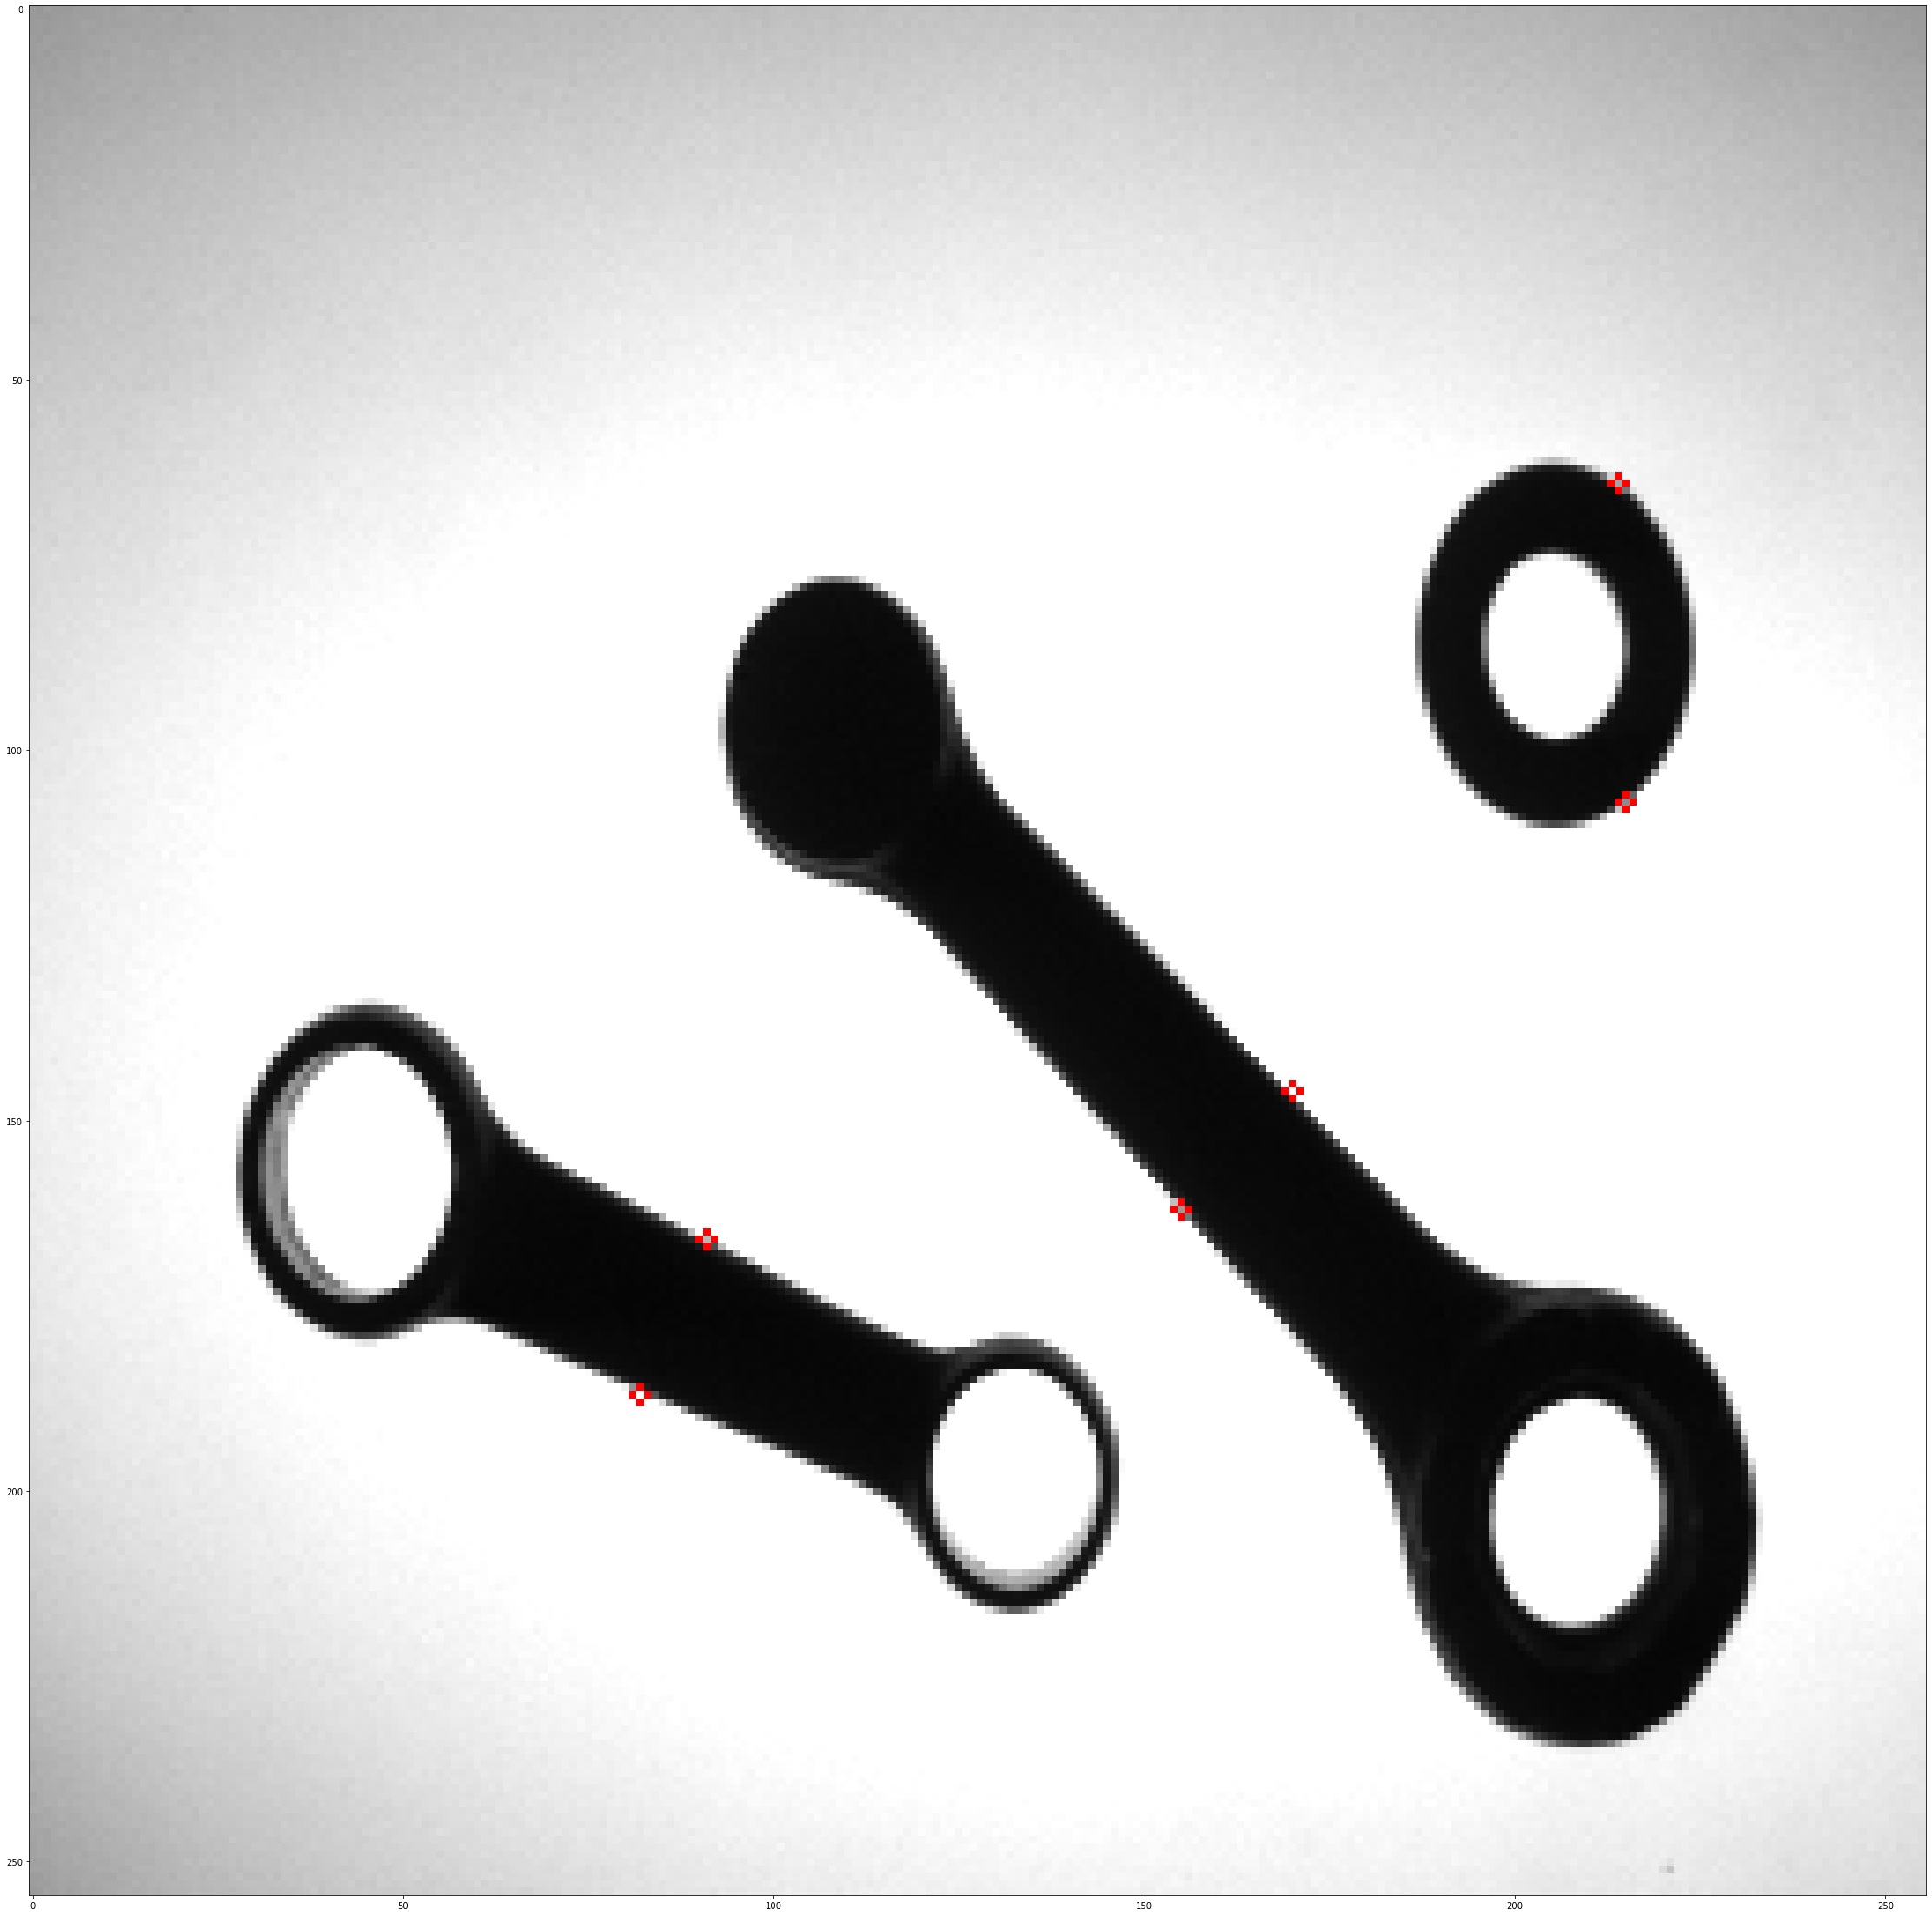

In [477]:
import math

plt.figure(figsize=(40,40))

def get_coords(x, y, angle):

    length = 10
    endx1 = x + length * math.cos(math.radians(angle))
    endy1 = y + length * math.sin(math.radians(angle))

    endx2 = x + length * math.cos(math.radians(angle+180))
    endy2 = y + length * math.sin(math.radians(angle+180))

    return round(endx1), round(endy1), round(endx2), round(endy2)

img = cv.cvtColor(original_img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72: # hierarchy[0, i][3] == 0 : if my parent is zero, it means that I'am a rod.
        rect = cv.minAreaRect(contours[i])                                              # hierarchy[0, i][2] != -1 : if a rod has a first child, it means it is a rod and not a screw, so it will be analyzed.
        
        
        ellipse = cv.fitEllipse(contours[i])
        (xc,yc),(d1,d2), angle = ellipse
        
        rmajor = max(d1,d2)
        if angle > 90:
            angle = angle - 90
        else:
            angle = angle + 90
        #print(angle)
        
        angle1 = angle+90
        angle2 = 180+angle+90
        if rect[2] <= 0 or (rect[2] >= 69 and rect[2] < 70):
            angle1 = rect[2]+90
            angle2 = 180+rect[2]+90
        a,b,c,d = get_coords(round(rect[0][0]), round(rect[0][1]), angle1)
        #cv.line(img,(round(rect[0][0]), round(rect[0][1])),(c,d),(255,0, 0),3)

        
        distance_from_i_to_j = math.inf
        index_of_j = -1
        for j in range(len(contours[i])):
            dst = distance.euclidean([c, d], [contours[i][j][0][0], contours[i][j][0][1]])
            if dst < distance_from_i_to_j:
                distance_from_i_to_j = dst
                index_of_j = j
        
        img = cv.circle(img, center=(contours[i][index_of_j][0][0], contours[i][index_of_j][0][1]), radius=1, color=(255, 0, 0) , thickness=1) 
        #img = cv.circle(img, center=(c,d), radius=1, color=(0, 255, 0) , thickness=1) 
        #print("red: ", contours[i][index_of_j][0][0], contours[i][index_of_j][0][1])
        #print("green: ", c,d)
        
        #cv.drawContours(img, contours[i], -1, color=(255, 255, 255), thickness=cv.FILLED)
        
        
        a,b,c,d = get_coords(round(rect[0][0]), round(rect[0][1]), angle2)
        
        distance_from_i_to_j = math.inf
        index_of_j = -1
        for j in range(len(contours[i])):
            dst = distance.euclidean([c, d], [contours[i][j][0][0], contours[i][j][0][1]])
            if dst < distance_from_i_to_j:
                distance_from_i_to_j = dst
                index_of_j = j
        
        img = cv.circle(img, center=(contours[i][index_of_j][0][0], contours[i][index_of_j][0][1]), radius=1, color=(255, 0, 0) , thickness=1) 
        #img = cv.circle(img, center=(c,d), radius=1, color=(0, 255, 0) , thickness=1) 
        #print(c,d)
        
        
        
        plt.imshow(img, cmap = 'gray')
        
        
plt.show()

In [420]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [315]:
import math

def get_coords(x, y, angle):

    length = 50
    endx1 = x + length * math.cos(math.radians(angle))
    endy1 = y + length * math.sin(math.radians(angle))

    endx2 = x + length * math.cos(math.radians(angle+180))
    endy2 = y + length * math.sin(math.radians(angle+180))

    return round(endx1), round(endy1), round(endx2), round(endy2)